# Online Laboratory for Data Compression in Climate Science and Meteorology

> [!NOTE]
> The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.

> [!CAUTION]
> Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

## Import the field compression benchmarking library

Importing `fcbench` also imports a large number of dependencies, which may take around a minute. Why not use this time to grab a drink, stretch your legs, and look out of your window?

In [1]:
import fcbench

[pyodide]: Loading field-compression-benchmark, cfgrib, attrs, click, eccodes, cffi, pycparser, findlibs, xarray, pandas, tzdata, dask, cloudpickle, importlib_metadata, zipp, Jinja2, MarkupSafe, partd, locket, toolz, pyyaml, netcdf4, cftime, h5py, pkgconfig, numcodecs, msgpack, pint, typing-extensions, xeofs, pooch, lzma, platformdirs, scikit-learn, scipy, openblas, joblib, distutils, threadpoolctl, statsmodels, patsy, tqdm, xarray-datatree, zarr, asciitree, xhistogram
[pyodide]: Loaded Jinja2, MarkupSafe, asciitree, attrs, cffi, cfgrib, cftime, click, cloudpickle, dask, distutils, eccodes, field-compression-benchmark, findlibs, h5py, importlib_metadata, joblib, locket, lzma, msgpack, netcdf4, numcodecs, openblas, pandas, partd, patsy, pint, pkgconfig, platformdirs, pooch, pycparser, pyyaml, scikit-learn, scipy, statsmodels, threadpoolctl, toolz, tqdm, typing-extensions, tzdata, xarray, xarray-datatree, xeofs, xhistogram, zarr, zipp


Many Python packages that are common in scientific computing and meteorology are available in this lab and can simply be imported. These include, e.g., `cartopy`, `cfgrib`, `dask`, `earthkit`, `matplotlib`, `metpy`, `netcdf4`, `numcodecs`, `numpy`, `pandas`, `xarray`, and `zarr`.

If you want to use a package that fails to import, you can first try to install it from PyPi by running a code cell similar to the following, which installs `tqdm`:

In [2]:
%pip install tqdm
import tqdm

Note that this installation only works for *pure* Python packages, i.e. those that only include Python code and only have pure or pre-installed dependencies. If you cannot install your packages this way, please report the missing package in the issue tracker below:

https://github.com/climet-eu/lab/issues/

## Fetch an example dataset

We use `xarray` to load datasets into this laboratory. Since the lab might run in memory constrained environments, we configure `dask` to use a small chunk size so that even large datasets can be streamed efficiently.

In [3]:
import dask

dask.config.set(array__chunk_size="4MiB");

The `utils.py` file next to this notebook defines several helper functions to conveniently load datasets from different sources.

In [4]:
import utils

[pyodide]: Loading sympy, mpmath, kerchunk, fsspec, ujson, ipyfilite, ipywidgets, widgetsnbextension, jupyterlab_widgets
[pyodide]: Loaded fsspec, ipyfilite, ipywidgets, jupyterlab_widgets, kerchunk, mpmath, sympy, ujson, widgetsnbextension


### Download a small dataset into memory

For this introduction, we download a small dataset that will be saved in the in-memory file system of this JupyterLite notebook.

This approach is only suitable for small datasets ($\leq 10$MB in size) as memory is limited. The [`02-data-sources`](02-data-sources/00-README.md) directory explores several approaches to load large datasets, including opening them remotely.

In [5]:
from pathlib import Path

data_path = Path("data") / "01-t2m.nc"

In [6]:
import shutil
from urllib.request import urlopen

data_url = "https://a3s.fi/compression.lab.climet.eu/era5_t2m_2012_12_01_14:00.nc"

with urlopen(data_url) as response:
    with data_path.open("wb") as file:
        shutil.copyfileobj(response, file)

## Load the example dataset into `xarray`

We can now load the dataset into `xarray`.
```python
utils.open_dataset(path: pathlib.Path, **kwargs) -> xarray.Dataset
```
is a thin wrapper around
```python
xarray.open_dataset(filename: str, **kwargs) -> xarray.Datset
```
and thus takes the same arguments. Please refer to the [`xarray.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) documentation if you need to perform some special configuration.

In [7]:
import numpy as np
import xarray as xr

ds = utils.open_dataset(data_path)
ds

<xarray.Dataset>
Dimensions:     (valid_time: 1, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2012-12-01T14:00:00
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      <U4 ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-08T07:34 GRIB to CDM+CF via cfgrib-0.9.1...
    path:                    data/01-t2m.nc

In this example, we will focus on the two-metre temperature variable `t2m` from the dataset.

In [8]:
da = ds["t2m"].rename(dict(valid_time="time"))

## Plot the loaded dataset

In [9]:
import earthkit
import earthkit.plots.quickmap

[pyodide]: Loading earthkit, earthkit-data, Cartopy, shapely, pyshp, pyproj, geos, cdsapi, cads-api-client, multiurl, setuptools, earthkit-geo, earthkit-meteo, ecmwf-api-client, ecmwf-opendata, entrypoints, filelock, geopandas, fiona, cligj, jsonschema, pyrsistent, lru-dict, markdown, pdbufr, earthkit-plots, adjustText, earthkit-plots-default-styles, earthkit-regrid, earthkit-transforms, rasterio, affine, gdal, click-plugins
[pyodide]: Loaded Cartopy, adjustText, affine, cads-api-client, cdsapi, click-plugins, cligj, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-transforms, ecmwf-api-client, ecmwf-opendata, entrypoints, filelock, fiona, gdal, geopandas, geos, jsonschema, lru-dict, markdown, multiurl, pdbufr, pyproj, pyrsistent, pyshp, rasterio, setuptools, shapely


/lib/python3.11/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


We first plot the loaded dataset. `earthkit` provides the
```python
earthkit.plots.quickmap.plot(
    data, units=None, style=None, **kwargs,
) -> earthkit.plots.components.maps.Map
```
helper function to plot weather and climate maps data, which we utilize in our `plot_data` function.

In [10]:
def auto_range(data, divergence_point=None, n_levels=8):
    min_value = np.nanmin(data)
    max_value = np.nanmax(data)

    if divergence_point is not None:
        max_diff = max(max_value - divergence_point, divergence_point - min_value)
        max_value = max_diff
        min_value = -max_diff

    data_range = max_value - min_value

    initial_bin = data_range / n_levels

    magnitude = 10 ** (np.floor(np.log10(initial_bin)))
    bin_width = initial_bin - (initial_bin % -magnitude)

    min_value -= min_value % bin_width
    max_value -= max_value % -bin_width

    if divergence_point is not None:
        min_value += divergence_point
        max_value += divergence_point

    return np.linspace(
        min_value,
        max_value,
        n_levels + 1,
    ).tolist()

In [11]:
import numpy as np
import pandas as pd

def xarray_source_datetime(self):
    datetimes = [pd.to_datetime(dt).to_pydatetime() for dt in np.atleast_1d(self.data.time.values)]
    return {
        "base_time": datetimes,
        "valid_time": datetimes,
    }
earthkit.plots.sources.XarraySource.datetime = xarray_source_datetime

In [12]:
def format_units(units, exponential_notation=False):
    units = earthkit.plots.metadata.units._pintify(units)
    if units.dimensionless:
        return "dimensionless"
    latex_str = f"{units:~L}"
    if exponential_notation:
        raise NotImplementedError("Exponential notation is not yet supported.")
    return f"${latex_str}$"
earthkit.plots.metadata.units.format_units = format_units

In [13]:
import copy

def plot_data(da: xr.DataArray, title_prefix="", title_postfix="", error=False):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)
    
    units = None if error else UNITS.get(da.name, None)
    divergence_point = 0.0 if error else DIVERGENCE_POINT.get(da.name, None)

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(earthkit.plots.styles.auto.guess_style(
        source, units=units or source.units,
    ))

    da_units = style.convert_units(da.values, source.units)
    
    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(auto_range(
        da_units,
        divergence_point=divergence_point, n_levels=256,
    ))
    style._legend_kwargs["ticks"] = auto_range(
        da_units,
        divergence_point=divergence_point, n_levels=10,
    )

    # force the colourmap to coolwarm for error plots
    style._colors = "coolwarm" if error else style._colors

    # quickplot with the modified style
    chart = earthkit.plots.quickmap.plot(
        da, units=units, style=style,
    )

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    chart.show()

/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


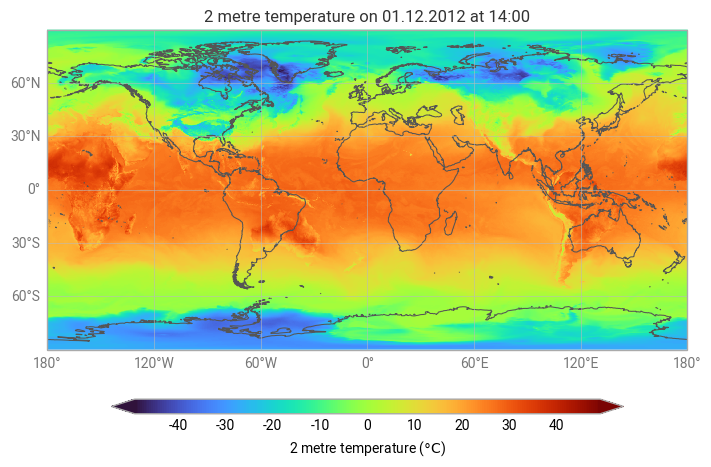

In [14]:
plot_data(da)

## Apply one of many compression methods

`fcbench` provides some helper functions to compress your data with codecs implementing the `numcodecs` API. `fcbench.codecs` also comes with built-in support for several compression codecs, which we first have to preload.

In [15]:
fcbench.codecs.preload()

Loaded the fcbench.codecs.Asinh codec ...
Loaded the fcbench.codecs.BitRound codec ...
Loaded the fcbench.codecs.FixedOffsetScale codec ...
Loaded the fcbench.codecs.Identity codec ...
Loaded the fcbench.codecs.LinearQuantize codec ...
Loaded the fcbench.codecs.Log codec ...
Loaded the fcbench.codecs.RandomProjection codec ...
Loaded the fcbench.codecs.Reinterpret codec ...
Loaded the fcbench.codecs.Round codec ...
Loaded the fcbench.codecs.SwizzleReshape codec ...
Loaded the fcbench.codecs.Sz3 codec ...
Loaded the fcbench.codecs.UniformNoise codec ...
Loaded the fcbench.codecs.Zfp codec ...
Loaded the fcbench.codecs.Zlib codec ...
Loaded the fcbench.codecs.Zstd codec ...


You can always find out more about how a particular codec works and what configuration parameters it takes by checking its documentation:

In [16]:
?fcbench.codecs.Zfp

Init signature:
fcbench.codecs.Zfp(
    mode,
    max_bits=None,
    max_prec=None,
    min_bits=None,
    min_exp=None,
    precision=None,
    rate=None,
    tolerance=None,
    **kwargs,
)
Docstring:     
# zfp (ZfpCompressionMode)

ZFP compression mode

## Parameters

 - mode (required): 
    - "expert": The most general mode, which can describe all four other modes
    - "fixed-rate": In fixed-rate mode, each d-dimensional compressed block of 4^d values
    is stored using a fixed number of bits. This number of compressed bits
    per block is amortized over the 4^d values to give a rate of
    `rate = max_bits / 4^d` in bits per value.
    - "fixed-precision": In fixed-precision mode, the number of bits used to encode a block may
    vary, but the number of bit planes (the precision) encoded for the
    transform coefficients is fixed.
    - "fixed-accuracy": In fixed-accuracy mode, all transform coefficient bit planes up to a
    minimum bit plane number are encoded. The smalles

### Apply the transform-based ZFP compressor

ZFP is a lossy transform-based compressor that compresses multidimensional data in $4^d$ chunks where $d$ is the dimensionality of the data. All values in the chunk are decorrelated and then transformed into a binary plane embedding that is roughly ordered by importance. The resulting per-chunk bitstream can be truncated to satisfy a user-provided compression target, e.g. a fixed number of bits, a bitplane precision, or an absolute error tolerance.

You can find out more about the ZFP compressor in its [documentation](https://zfp.readthedocs.io/en/latest/index.html) and the following two publications:

> Diffenderfer, J. et *al*. (2019). Error Analysis of ZFP Compression for Floating-Point Data. *SIAM Journal on Scientific Computing*. 41(3). pp. A1867-A1898. Available from: [doi:10.1137/18M1168832](https://doi.org/10.1137/18M1168832).

> Lindstrom, P. (2014). Fixed-Rate Compressed Floating-Point Arrays. *IEEE Transactions on Visualization and Computer Graphics*. 20(2). pp. 2674-2683. Available from: [doi:10.1109/TVCG.2014.2346458](https://doi.org/10.1109/TVCG.2014.2346458).

To use ZFP with a relative error bound, we first transform the input into a quasi-logarithmic space and then apply ZFP's absolute error tolerance mode. After decompressing the data, we finally transform it back.

In [17]:
zfp_compressor = [
    fcbench.codecs.Asinh(linear_width=1.0),
    fcbench.codecs.Zfp(mode="fixed-accuracy", tolerance=1e-2),
]

da_zfp, stats_zfp = (
    fcbench.compressor.compute_dataarray_compress_decompress(da, zfp_compressor)
)
display(utils.format_compress_stats(zfp_compressor, stats_zfp))

zfp_compressor = str(zfp_compressor)

,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
Asinh(linear_width=1.0),1.00,0.06,0.05,6.0,9.0
"Zfp(mode='fixed-accuracy', tolerance=0.01)",4.83,0.02,0.03,20.1,9.6


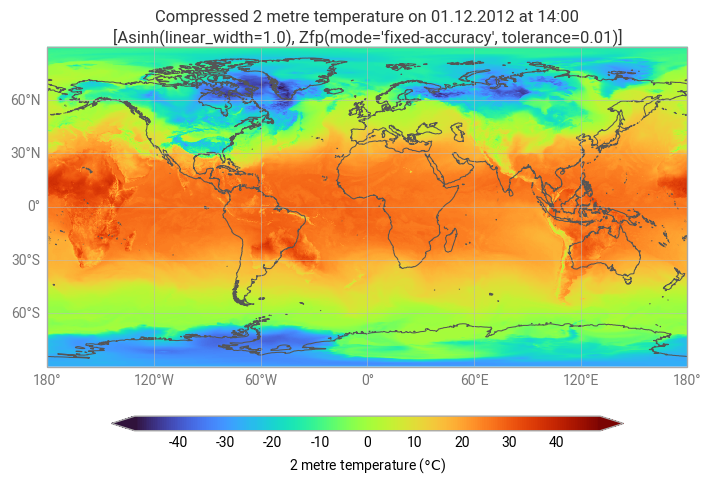

In [18]:
plot_data(
    da_zfp, title_prefix="Compressed ", title_postfix=f"\n{zfp_compressor}",
)

### Plot the ZFP compression error

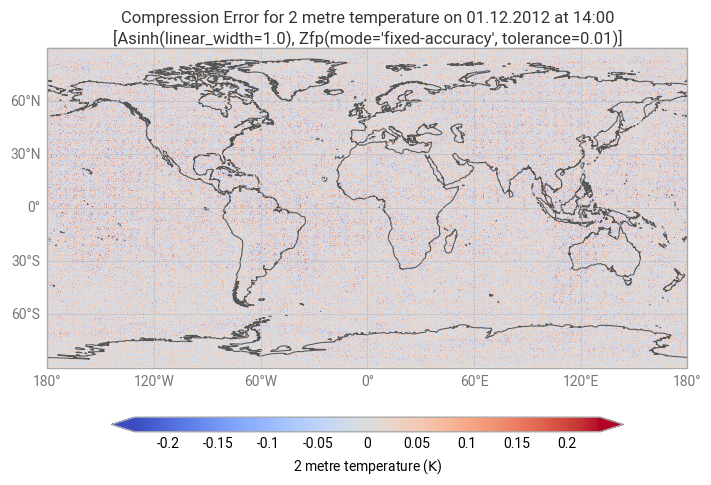

In [19]:
with xr.set_options(keep_attrs=True):
    da_zfp_error = (da_zfp - da).compute()

plot_data(
    da_zfp_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{zfp_compressor}", error=True,
)

## Save the dataset for further use

If you want to perform further work on the (compressed) data outside or in a new session of the compression lab, you can download the data to your computer. Note that the writes are directly streamed to the download and it is thus not possible to skip around the file (seek) or read written back during the download.

### (a) Download the compressed data

You can save the compressed dataset as a single `.zip` file in the [ZARR format](https://zarr.readthedocs.io/en/stable/spec.html). Note that this approach takes the uncompressed dataset and runs the provided compression as the dataset is downloaded.

For instance, here we download the dataset compressed using the SZ3 compressor from above. You can also download the uncompressed dataset by passing `compressor=[]` to the following helper function:
```python
await utils.download_dataset_as_zarr(
    ds: xr.Dataset,
    name: str,
    compressor: Union[
        numcodecs.abc.Codec,
        list[numcodecs.abc.Codec],
        dict[str, Union[
            numcodecs.abc.Codec,
            list[numcodecs.abc.Codec],
        ]],
    ],
    zip_compression: int = 0,
)
```

In [20]:
from pathlib import Path

compressed_download_name = Path(ds.attrs.get("path", "ds")).name
compressed_download_name = compressed_download_name[
    : compressed_download_name.find(".")
]
compressed_download_name = f"{compressed_download_name}-compressed.zarr.zip"
compressed_download_name

'01-t2m-compressed.zarr.zip'

In [21]:
await utils.download_dataset_as_zarr(
    ds, compressed_download_name, compressor=[fcbench.codecs.BitRound(keepbits=8)]
)

### (b) Download arbitrary files

You can also download arbitrary files. The compression lab provides the following (asynchronous context manager) construct to obtain a file system path to which the to-be-downloaded file can be written inside the `async with` block:
```python
async with utils.file_download_path("my-file.txt") as download_path:
    with open(download_path, "w") as download:
        download.write("Hello world!")
```
Note again that the special download files do not provide random access but are append-only streams. Since, e.g. NetCDF file writes require random access, they cannot be directly downloaded but must go through a temporary file first (see option **(c)** below).

### (c) Download (small) files from the (in-memory) file system

If your file already exists within the file system, you can download them directly. For instance, you can download small files that are stored in the in-memory file system. If you want to download small files that need seeks or reads during writing, you can first write them to the in-memory file system and then download them.

For instance, here we create, write to, and then partially overwrite a text file, before we download it.

In [22]:
import io
import shutil

with open("demo.txt", "wb") as file:
    file.write(b"This text is wrong")
    file.seek(-len(b"wrong"), io.SEEK_CUR)
    file.write(b"correct")

async with utils.file_download_path("demo.txt") as download_path:
    shutil.copyfile("demo.txt", download_path)

## Feedback on the Online Laboratory for Data Compression in Climate Science and Meteorology

We aim to build an online laboratory for data compression in which you can easily test and apply the most relevant compression algorithms on your data. We want to hear from you about what your requirements for compression are to ensure that any downstream scientific analysis is not adversely affected.

Please use the below links to provide us with feedback on

- your requirements for compression
- any bugs in the compression lab
- missing features that would allow you to better use it (e.g. unsupported data formats, compression methods, or compression error analysis methods)
- complicated or unclear functionality in the compression lab

https://github.com/climet-eu/lab/issues/

https://github.com/climet-eu/compression-lab-notebooks/issues

## Funding

The Online Laboratory for Data Compression in Climate Science and Meteorology has been developed as part of [ESiWACE3](https://www.esiwace.eu), the third phase of the Centre of Excellence in Simulation of Weather and Climate in Europe.